In [1]:
from ctypes import util
from statistics import mode
from sklearn.utils import shuffle
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd import Variable

In [20]:
class trafficData(Dataset):
    def __init__(self, file_path, preprocesser=None, transform=None):
        self.file_path = file_path
        self.normal_data_path = file_path + "/normal"
        self.abnormal_data_path = file_path + "/abnormal"
        self.data1 = []
        self.data0 = []
        normal_filenames = next(os.walk(self.normal_data_path), (None, None, []))[2]
        abnormal_filenames = next(os.walk(self.abnormal_data_path), (None, None, []))[2]
        for filename in normal_filenames:
            with open(self.normal_data_path + "/" + filename, "rb") as f:
                datas = f.read()
            if transform:
                datas = transform(datas)
            self.data1.append((datas, torch.tensor(0)))
        for filename in abnormal_filenames:
            with open(self.abnormal_data_path + "/" + filename, "rb") as f:
                datas = f.read()
            if transform:
                datas = transform(datas)
            self.data0.append((datas, torch.tensor(1)))
        shuffle(self.data0)
        shuffle(self.data1)
        min_size = np.min([len(self.data0), len(self.data1)])
        self.data0 = self.data0[:min_size]
        self.data1 = self.data1[:min_size]
        self.data = self.data0 + self.data1
        if preprocesser:
            self.data = preprocesser(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        target, label = self.data[index]
        return target, label

In [49]:
def SRU_traffic_transform(data, N=10):
    length = N * 50
    if len(data) > length:
        data = data[:length]
    elif len(data) < length:
        data = data + b"\x00" * (length - len(data))
    float_data = np.frombuffer(data, dtype=np.ubyte)
    float_data = float_data / 255.0
    float_data = float_data.reshape((50, N))
    float_data = torch.tensor(float_data, dtype=torch.float32)
    return float_data[~torch.any(float_data.isnan(),dim=1)]

SRU测试，寄了
梯度爆炸，找不着哪边出了问题
:::需要帮助:::

In [65]:
from sru import SRU, SRUCell

class SRU_Net(torch.nn.Module):
    def __init__(
        self, batch_size, output_size, hidden_size, dropout,
        embed_dim, bidirectional, use_cuda, attention_size, sequence_length
    ):
        super(SRU_Net, self).__init__()

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.embed_dim = embed_dim
        self.bidirectional = bidirectional
        self.use_cuda = use_cuda
        self.sequence_length = sequence_length
        self.dropout = dropout

        self.layer_size = 2

        self.lstm = SRU(
            input_size=self.embed_dim,
            hidden_size=self.hidden_size,
            num_layers=self.layer_size,
            dropout=self.dropout,
            bidirectional=True,
        )

        # self.lstm = nn.LSTM(self.embed_dim,
        #                     self.hidden_size,
        #                     self.layer_size,
        #                     dropout=self.dropout,
        #                     bidirectional=self.bidirectional)

        self.attention_size = attention_size
        if self.use_cuda:
            self.w_omega = Variable(torch.randn(self.hidden_size * self.layer_size, self.attention_size).to(torch.device("cuda")))
            self.u_omega = Variable(torch.randn(self.attention_size).to(torch.device("cuda")))
        else:
            self.w_omega = Variable(torch.randn(self.hidden_size * self.layer_size, self.attention_size))
            self.u_omega = Variable(torch.randn(self.attention_size))

        self.label = nn.Linear(hidden_size * self.layer_size, output_size)

    # self.attn_fc_layer = nn.Linear()

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output, [-1, self.hidden_size*self.layer_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer), [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas, [-1, self.sequence_length, 1])
        state = lstm_output.permute(1, 0, 2)
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, data):
        data = data.permute(1, 0, 2)
        lstm_output, (final_hidden_state, final_cell_state) = self.lstm(data)
        attn_output = self.attention_net(lstm_output)
        logits = self.label(attn_output)
        return logits

In [50]:
dataset = trafficData(
    file_path = "/home/syml/Sources/MiningProcess/split_flow/",
    preprocesser = None,
    transform = SRU_traffic_transform,
)
batch_size = 1
train_set, test_set = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, shuffle=True)

In [6]:
data_, label_ = train_set[0]
print(data_.shape)
print(data_[0][0])

torch.Size([50, 10])
tensor(0.2706)


In [94]:
def train(model, device, train_loader, criterion, optimizer, epoch, batch_size):
    model.train()
    correct_list = []
    loss_list = []
    correct = 0
    cnt = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        cnt += batch_size
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and batch_idx != 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} acc: {:.2f}'.format(
                epoch, batch_idx  * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / cnt))
            correct_list.append(correct / cnt)
            loss_list.append(loss.item())
    return correct_list, loss_list

def test(model, device, criterion, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader)))

    return test_loss, correct / len(test_loader)

In [69]:
#self, batch_size, output_size, hidden_size, 
#        embed_dim, bidirectional, use_cuda, attention_size, sequence_length
net = SRU_Net(
    batch_size=batch_size,
    output_size=2,
    hidden_size=50,
    dropout=0.5,
    embed_dim=50,
    bidirectional=True,
    use_cuda=torch.cuda.is_available(),
    attention_size=50,
    sequence_length=50,
    
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
net.to(device)
#criterion = nn.CrossEntropyLoss(reduce="sum")
criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001)
epoches = 10
loss_list = []
acc_list = []
acc_train_set = []
loss_train_set = []
for epoch in range(1, epoches + 1):
    acc_train, loss_train = train(net, device, train_loader, criterion, optimizer, epoch, batch_size)
    loss, acc = test(net, device, criterion, test_loader)
    loss_list.append(loss)
    acc_list.append(acc)
    acc_train_set += acc_train
    loss_train_set += loss_train


Train Epoch: 1 [100/508 (20%)]	Loss: nan acc: 43.56
Train Epoch: 1 [200/508 (39%)]	Loss: nan acc: 49.25
Train Epoch: 1 [300/508 (59%)]	Loss: nan acc: 47.84
Train Epoch: 1 [400/508 (79%)]	Loss: nan acc: 50.37
Train Epoch: 1 [500/508 (98%)]	Loss: nan acc: 49.90

Test set: Average loss: nan, Accuracy: 64/128 (50%)

Train Epoch: 2 [100/508 (20%)]	Loss: nan acc: 51.49
Train Epoch: 2 [200/508 (39%)]	Loss: nan acc: 51.24
Train Epoch: 2 [300/508 (59%)]	Loss: nan acc: 49.50
Train Epoch: 2 [400/508 (79%)]	Loss: nan acc: 50.12
Train Epoch: 2 [500/508 (98%)]	Loss: nan acc: 50.50

Test set: Average loss: nan, Accuracy: 64/128 (50%)

Train Epoch: 3 [100/508 (20%)]	Loss: nan acc: 47.52
Train Epoch: 3 [200/508 (39%)]	Loss: nan acc: 50.25
Train Epoch: 3 [300/508 (59%)]	Loss: nan acc: 47.84
Train Epoch: 3 [400/508 (79%)]	Loss: nan acc: 47.13
Train Epoch: 3 [500/508 (98%)]	Loss: nan acc: 49.70

Test set: Average loss: nan, Accuracy: 64/128 (50%)

Train Epoch: 4 [100/508 (20%)]	Loss: nan acc: 53.47
Train 

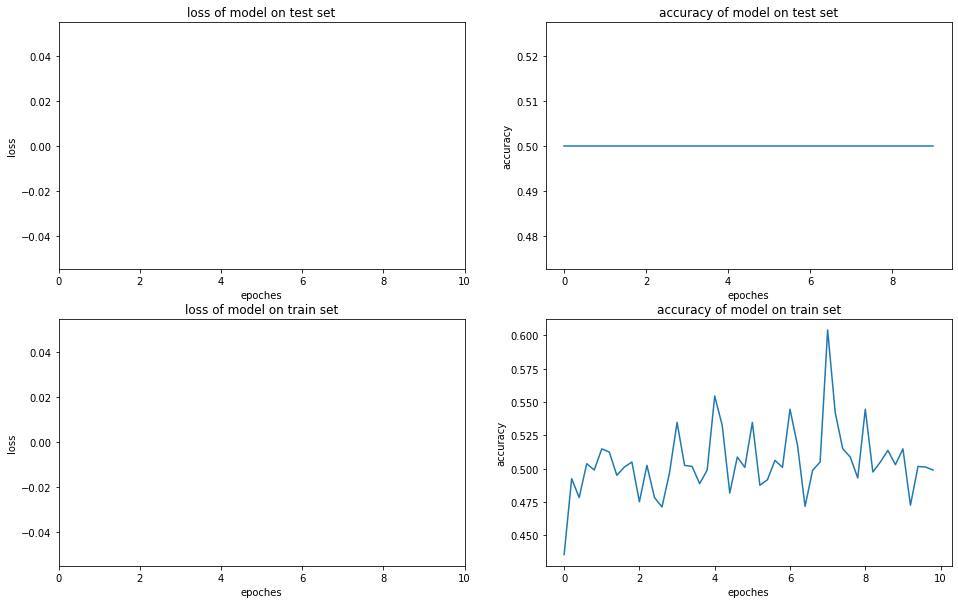

In [70]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.title("loss of model on test set")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.xlim((0, 10))
plt.plot(loss_list)
plt.subplot(222)
plt.title("accuracy of model on test set")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.plot(acc_list)
plt.subplot(223)
plt.title("loss of model on train set")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.xlim((0, 10))
plt.plot(np.arange(0, epoches, epoches/len(loss_train_set)), loss_train_set)
plt.subplot(224)
plt.title("accuracy of model on train set")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.plot(np.arange(0, epoches, epoches/len(acc_train_set)), acc_train_set)
plt.show()

试一下类似于LeNet的结构

In [71]:
def lenet_preprocesser(data):
    if len(data) > 1024:
        data = data[:1024]
    elif len(data) < 1024:
        data = data + b"\x00" * (1024 - len(data))
    float_data = np.frombuffer(data, dtype=np.ubyte)
    float_data = float_data / 255.0
    float_data = float_data.reshape((32, 32))
    float_data = torch.tensor(float_data, dtype=torch.float32)
    return float_data[~torch.any(float_data.isnan(),dim=1)]

In [95]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),padding=0,stride=1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = (5,5),padding=0,stride=1)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120,kernel_size = (5,5),padding=0,stride=1)
        self.L1 = nn.Linear(120,84)
        self.L2 = nn.Linear(84,2)
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.act = nn.Tanh()
    def forward(self,x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.act(x)
        x = x.view(-1, 120)
        x = self.L1(x)
        x = self.act(x)
        x = self.L2(x)
        return x

In [89]:
dataset = trafficData(
    file_path = "/home/syml/Sources/MiningProcess/split_flow/",
    preprocesser = None,
    transform = lenet_preprocesser,
)
batch_size = 1
train_set, test_set = random_split(dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, shuffle=True)

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("use device: ", device)
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(size_average=False)
epoches = 10
loss_list = []
acc_list = []
acc_train_set = []
loss_train_set = []
for epoch in range(1, epoches + 1):
    acc_train, loss_train = train(model, device, train_loader, criterion, optimizer, epoch, batch_size)
    loss, acc = test(model, device, criterion, test_loader)
    loss_list.append(loss)
    acc_list.append(acc)
    acc_train_set += acc_train
    loss_train_set += loss_train

use device:  cuda


/home/syml/Sources/MiningProcess/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [100/508 (20%)]	Loss: 0.317700 acc: 88.12
Train Epoch: 1 [200/508 (39%)]	Loss: 0.240712 acc: 89.05
Train Epoch: 1 [300/508 (59%)]	Loss: 0.001387 acc: 92.36
Train Epoch: 1 [400/508 (79%)]	Loss: 0.013753 acc: 93.77
Train Epoch: 1 [500/508 (98%)]	Loss: 0.005898 acc: 94.01

Test set: Average loss: 0.1498, Accuracy: 125/128 (98%)

Train Epoch: 2 [100/508 (20%)]	Loss: 0.000808 acc: 99.01
Train Epoch: 2 [200/508 (39%)]	Loss: 0.001255 acc: 99.00
Train Epoch: 2 [300/508 (59%)]	Loss: 0.007244 acc: 99.00
Train Epoch: 2 [400/508 (79%)]	Loss: 0.002337 acc: 99.00
Train Epoch: 2 [500/508 (98%)]	Loss: 0.001492 acc: 99.20

Test set: Average loss: 0.1524, Accuracy: 125/128 (98%)

Train Epoch: 3 [100/508 (20%)]	Loss: 0.002909 acc: 95.05
Train Epoch: 3 [200/508 (39%)]	Loss: 0.006359 acc: 96.02
Train Epoch: 3 [300/508 (59%)]	Loss: 0.011436 acc: 96.68
Train Epoch: 3 [400/508 (79%)]	Loss: 0.002965 acc: 97.51
Train Epoch: 3 [500/508 (98%)]	Loss: 0.000736 acc: 98.00

Test set: Average loss: 0.17

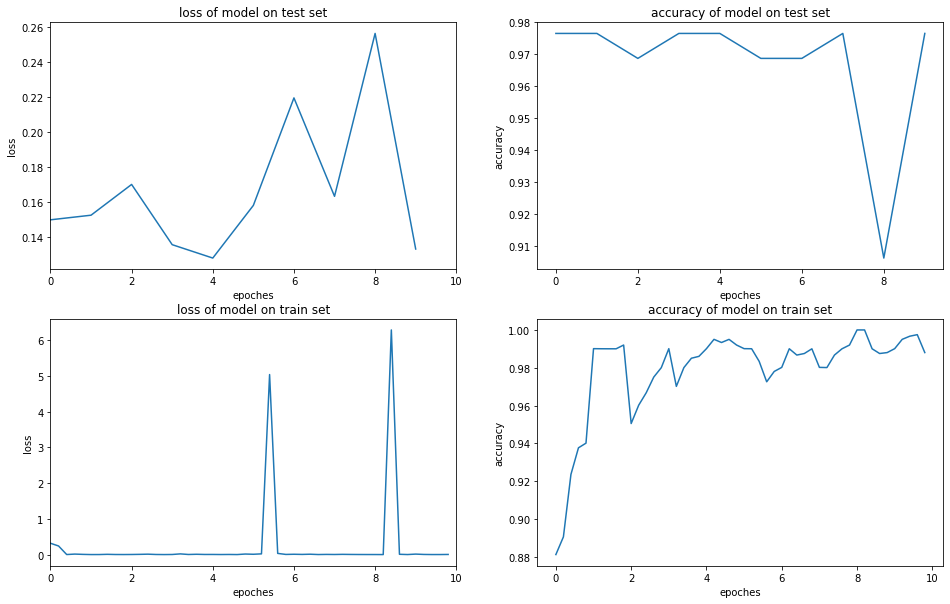

In [97]:
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.title("loss of model on test set")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.xlim((0, 10))
plt.plot(loss_list)
plt.subplot(222)
plt.title("accuracy of model on test set")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.plot(acc_list)
plt.subplot(223)
plt.title("loss of model on train set")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.xlim((0, 10))
plt.plot(np.arange(0, epoches, epoches/len(loss_train_set)), loss_train_set)
plt.subplot(224)
plt.title("accuracy of model on train set")
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.plot(np.arange(0, epoches, epoches/len(acc_train_set)), acc_train_set)
plt.show()